In [5]:
import os, sys
import rasterio
from rasterio.mask import mask
import numpy as np
from matplotlib import pyplot as plt
import glob
from xml.dom import minidom
import fiona
from shapely.geometry import mapping, shape
import scipy.misc as misc

%matplotlib inline

In [6]:
# function to return collection dates from Planet MultiSpectral image metadata
def getDates_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    date_node = xmldoc.getElementsByTagName("eop:acquisitionDate")
    date_str = str(date_node[0].firstChild.nodeValue)
    acq_date_yyyymmdd = date_str.split('T')[0]        
    
    return acq_date_yyyymmdd

# function to return correction coefficients from Planet MultiSpectral image metadata
def getCorrCoefs_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
            
    return coeffs

# function to extract image patch
def getImagePatch_planet(imfile, poly):
    
    try:
        with rasterio.open(imfile, 'r') as src:
            arr,_ = mask(src, [poly], crop=True)

        if arr.sum() != 0.:
            return arr
        else:
            return 0
        
    except:
        return 0

# function return geometries as geoJSON
def getGeometries_planet(shpfile):
    
    with fiona.open(shpfile, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]
        
    return geoms


def getMeansBand(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].mean())
    
    return res

def getSTDband(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].std())
    
    return res

def cor_ms(ms_temp, cf_arr):
    # extract the band means per patch
    ms_band1 = [b[0,:,:] for b in ms_temp]
    ms_band2 = [b[1,:,:] for b in ms_temp]
    ms_band3 = [b[2,:,:] for b in ms_temp]
    ms_band4 = [b[3,:,:] for b in ms_temp]
    
    # correct the ms images to TOA reflectance
    ms_band1_cor = [cf[0] * mn for cf,mn in zip(cf_arr, ms_band1)]
    ms_band2_cor = [cf[1] * mn for cf,mn in zip(cf_arr, ms_band2)]
    ms_band3_cor = [cf[2] * mn for cf,mn in zip(cf_arr, ms_band3)]
    ms_band4_cor = [cf[3] * mn for cf,mn in zip(cf_arr, ms_band4)]
    
    res = []
    for i in range(len(ms_band1_cor)):
        res.append(np.rollaxis(np.dstack((ms_band1_cor[i], ms_band2_cor[i], ms_band3_cor[i], ms_band4_cor[i])),2,0))
    
    return res
    
def meanIntensityOverGeometry_simple_Landsat(bandlist, poly):
    
    # SR scale factor
    sr_scale = 10000.
    
    # get the band patches. should be 4 of size 1xrowsxcols items, [blue, green, red, nir]
    band_patches = [getImagePatch_planet(im, poly) for im in bandlist]
    #band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches if type(arr) is np.ma.core.MaskedArray]
    band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches]
    #band_means = [getMeansBand(im,1) for im in band_temp]
    band_means = [im.mean() for im in band_temp]
    band_std = [im.std() for im in band_temp]
    
    res = {}
    res['sr_means'] = band_means
    res['numpixels'] = band_temp[0].count()
    res['sr_std'] = band_std
    
    #band_temp = [np.ma.masked_equal(arr, -9999.) for arr in band_temp]
    res['image'] = np.ma.array([b.squeeze() for b in band_temp])
    return res
    

# define function which process the planet images within a specified geometry
def meanIntensityOverGeometry_simple(im, xml, poly):
    
    # SR scale factor
    sr_scale = 10000.    
    
    #ms_patch = getImagePatch_planet(im, poly)
    sr_patch = getImagePatch_planet(im, poly) #/ sr_scale 
    
    coeffs = getCorrCoefs_planet(xml)
    date_s = getDates_planet(xml)
    
    #ms_patch_temp = [ms_patches[i] for i in xml_inds]
    #ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if type(arr) is np.ma.core.MaskedArray]
    #ms_cor = cor_ms(ms_temp, cf_arr) # correct the MS imagery to TOA reflectance
    #ms_means = [getMeansBand(arr,4) for arr in ms_cor]

    #sr_patch_temp = [sr_patches[i] for i in xml_inds]
    #sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if type(arr) is np.ma.core.MaskedArray]
    sr_temp = np.ma.masked_equal(sr_patch, 0.0) / sr_scale
    sr_means = getMeansBand(sr_temp,4)
    sr_stds = getSTDband(sr_temp, 4)
    
    
    
    # extract the band means per patch
    #ms_band1_mean = [b[0] for b in ms_means]
    #ms_band2_mean = [b[1] for b in ms_means]
    #ms_band3_mean = [b[2] for b in ms_means]
    #ms_band4_mean = [b[3] for b in ms_means]

    
    sr_band1_mean = sr_means[0] #/sr_scale 
    sr_band2_mean = sr_means[1] #/sr_scale 
    sr_band3_mean = sr_means[2] #/sr_scale 
    sr_band4_mean = sr_means[3] #/sr_scale
    
    sr_band1_std = sr_stds[0]
    sr_band2_std = sr_stds[1]
    sr_band3_std = sr_stds[2]
    sr_band4_std = sr_stds[3]
    
    # put the dates in a usable list corresponding to only overlapping images
    #date_arr = [dates[i] for i in xml_inds]

    res = {}
    #res['ms_means'] = [ms_band1_means, ms_band2_means, ms_band3_means, ms_band4_means]
    res['sr_means'] = [sr_band1_mean, sr_band2_mean, sr_band3_mean, sr_band4_mean]
    res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    res['dates'] = date_s
    res['numpixels'] = sr_temp[0,:,:].count()
    res['image'] = sr_temp
#     res['ms_std'] = [ms_band1_std_cor, ms_band2_std_cor, ms_band3_std_cor, ms_band4_std_cor]
#     res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    return res

In [7]:
# extract the data. it will be a bunch of lists
home_dir = r"C:\Projects\RD\planet\sample_order"
shp = r"C:\Projects\rd\planet\proj_cc_sites.shp"
polys = getGeometries_planet(shp)

# some filenames for the planet image
planet_dir = r'C:\Projects\RD\planet\sample_order\20170827_175918_0f24'
planet_image = os.path.join(planet_dir, '20170827_175918_0f24_3B_AnalyticMS_SR.tif')
planet_xml = planet_image.replace('MS_SR.tif', 'MS_metadata.xml')
planet_date = getDates_planet(planet_xml)
planet_cc = getCorrCoefs_planet(planet_xml)

# some filenames for the landsat image
landsat_dir = r'C:\projects\Forests\uav\landsat\LC080340322017082701T1-SC20170918170147'
landsat_base = os.path.join(landsat_dir, 'LC08_L1TP_034032_20170827_20170914_01_T1_sr_')

# construct landsat filenames
bands = ['band2', 'band3', 'band4', 'band5'] # [blue, green, red, nir]
landsat_bandfiles = ['{}{}.tif'.format(landsat_base, b) for b in bands]



In [8]:
# get the centroids of the polygons and buffer them
# convert to centroids
centroids = [shape(p).centroid for p in polys]

# buffer out 100 meters total. square capping.
buffer_distance = 50.
buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# convert them back to geojson
buffers = [mapping(b) for b in buffer_p]


In [9]:
# read the planet image over the buffered geometries
test = [meanIntensityOverGeometry_simple(planet_image, planet_xml, p) for p in buffers]

In [10]:
#for t in test: print(t)


In [11]:
test_landsat = [meanIntensityOverGeometry_simple_Landsat(landsat_bandfiles, p) for p in buffers]

In [12]:
#for t in test_landsat: print('{}\n'.format(t))

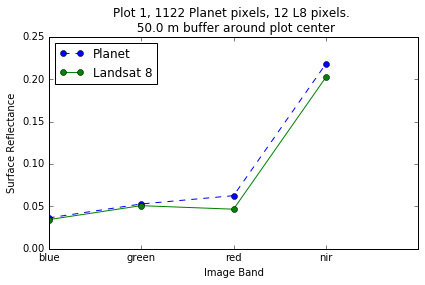

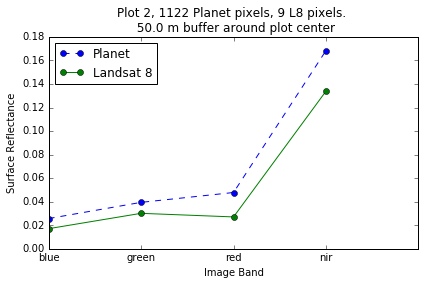

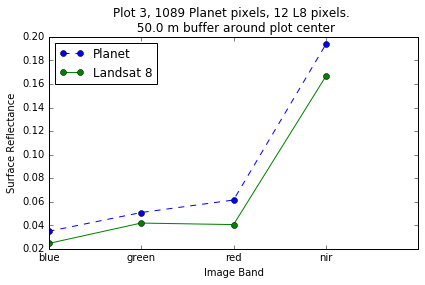

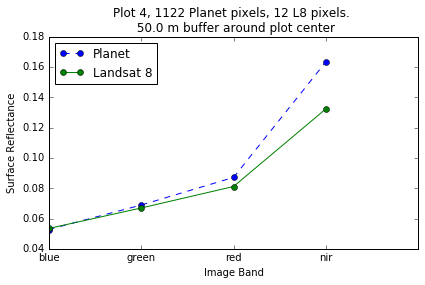

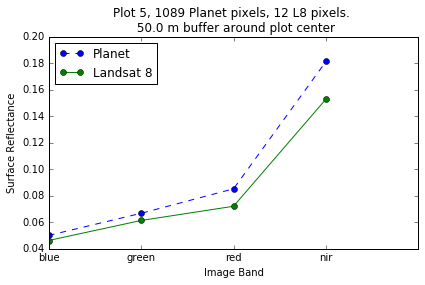

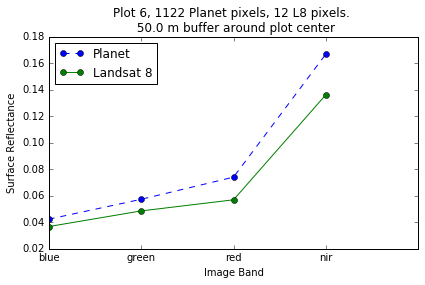

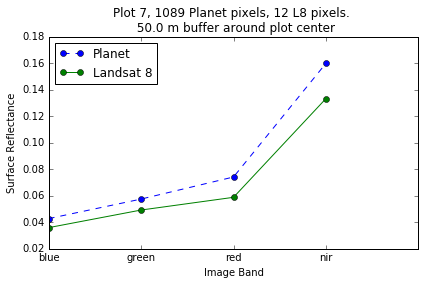

In [13]:
## plot the means

for i in range(7):
    
    plt.plot(test[i]['sr_means'], '--o', label="Planet")
    plt.plot(test_landsat[i]['sr_means'], '-o',label="Landsat 8")
    plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(i+1, test[i]['numpixels'],test_landsat[i]['numpixels'], buffer_distance))
    plt.legend(loc='upper left')
    xmarks = range(0, 4+1, 1)
    plt.xticks(xmarks)
    plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
    plt.xlabel('Image Band')
    plt.ylabel('Surface Reflectance')
    plt.tight_layout()
    plt.show()
    
    

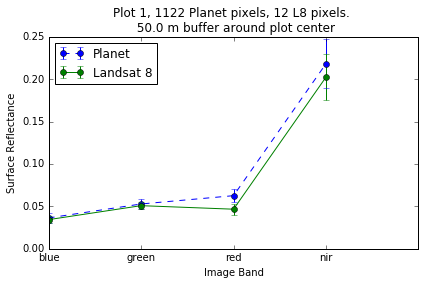

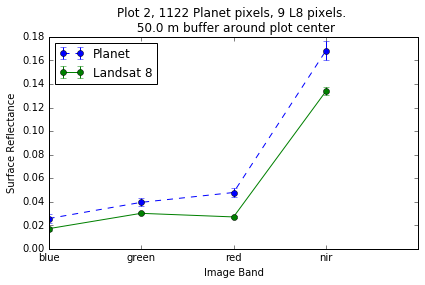

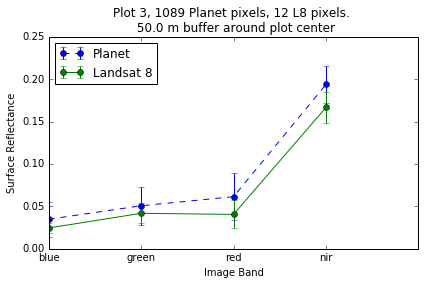

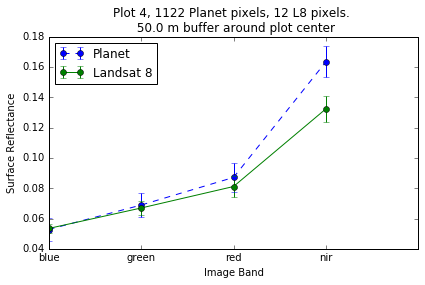

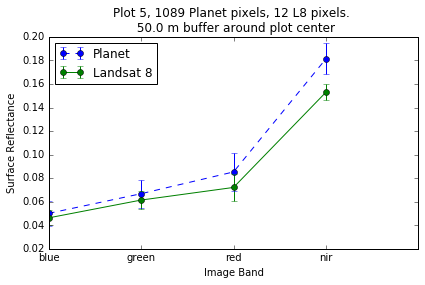

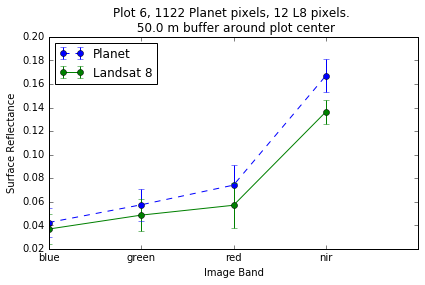

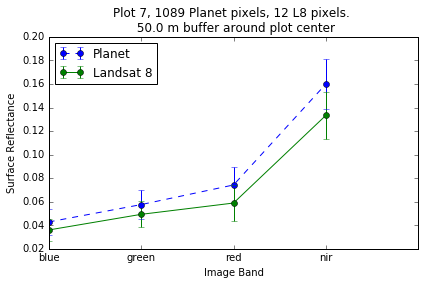

In [14]:
## plot the error bars
for i in range(7):
    
#     plt.plot(test[i]['sr_means'], '--o', label="Planet")
#     plt.plot(test_landsat[i]['sr_means'], '-o',label="Landsat 8")
    
    x = np.arange(4)
    plt.errorbar(x, test[i]['sr_means'], yerr=test[i]['sr_std'], fmt='--o', label="Planet")
    plt.errorbar(x, test_landsat[i]['sr_means'], yerr=test_landsat[i]['sr_std'], fmt='-o',label="Landsat 8")
    plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(i+1, test[i]['numpixels'],test_landsat[i]['numpixels'], buffer_distance))
    plt.legend(loc='upper left')
    xmarks = range(0, 4+1, 1)
    plt.xticks(xmarks)
    plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
    plt.xlabel('Image Band')
    plt.ylabel('Surface Reflectance')
    plt.tight_layout()
    plt.show()

In [15]:
# test[0], test_landsat[0]
len(test[0]['sr_std']), len(test_landsat[0]['sr_std']), len(test[0]['sr_means']), len(test_landsat[0]['sr_means'])

(4, 4, 4, 4)

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


numpy.ma.core.MaskedArray

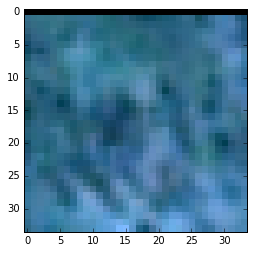

In [16]:
# iterate through some buffer sizes. save the figures
a = np.rollaxis(test[0]['image'][0:3,:,:],0,3)
a.shape
plt.imshow(misc.bytescale(a), interpolation='nearest')
type(a)

(4L, 4L, 3L)
0.0274
[[[-- -- --]
  [0.0321 0.0515 0.0413]
  [0.0274 0.0456 0.0379]
  [0.0335 0.0481 0.0451]]

 [[-- -- --]
  [0.0335 0.0532 0.0445]
  [0.0297 0.0503 0.0415]
  [0.0331 0.0501 0.0439]]

 [[-- -- --]
  [0.0309 0.0438 0.0407]
  [0.0354 0.0481 0.0484]
  [0.0348 0.0511 0.0474]]

 [[-- -- --]
  [0.0389 0.0546 0.0514]
  [0.0423 0.0564 0.0588]
  [0.0413 0.0579 0.0598]]]


C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


numpy.ma.core.MaskedArray

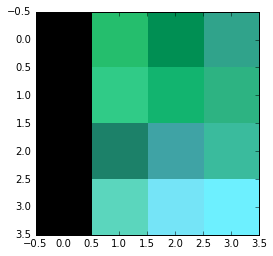

In [17]:
a = np.rollaxis(test_landsat[0]['image'][0:3,:,:], 0,3)
# a = test_landsat[0]['image'][0:3,:,:]
print(a.shape)

b = np.ma.masked_equal(a, -9999.)
plt.imshow(misc.bytescale(a), interpolation='nearest')

print(a.min())
print(a)
type(a)

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:31: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:37: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


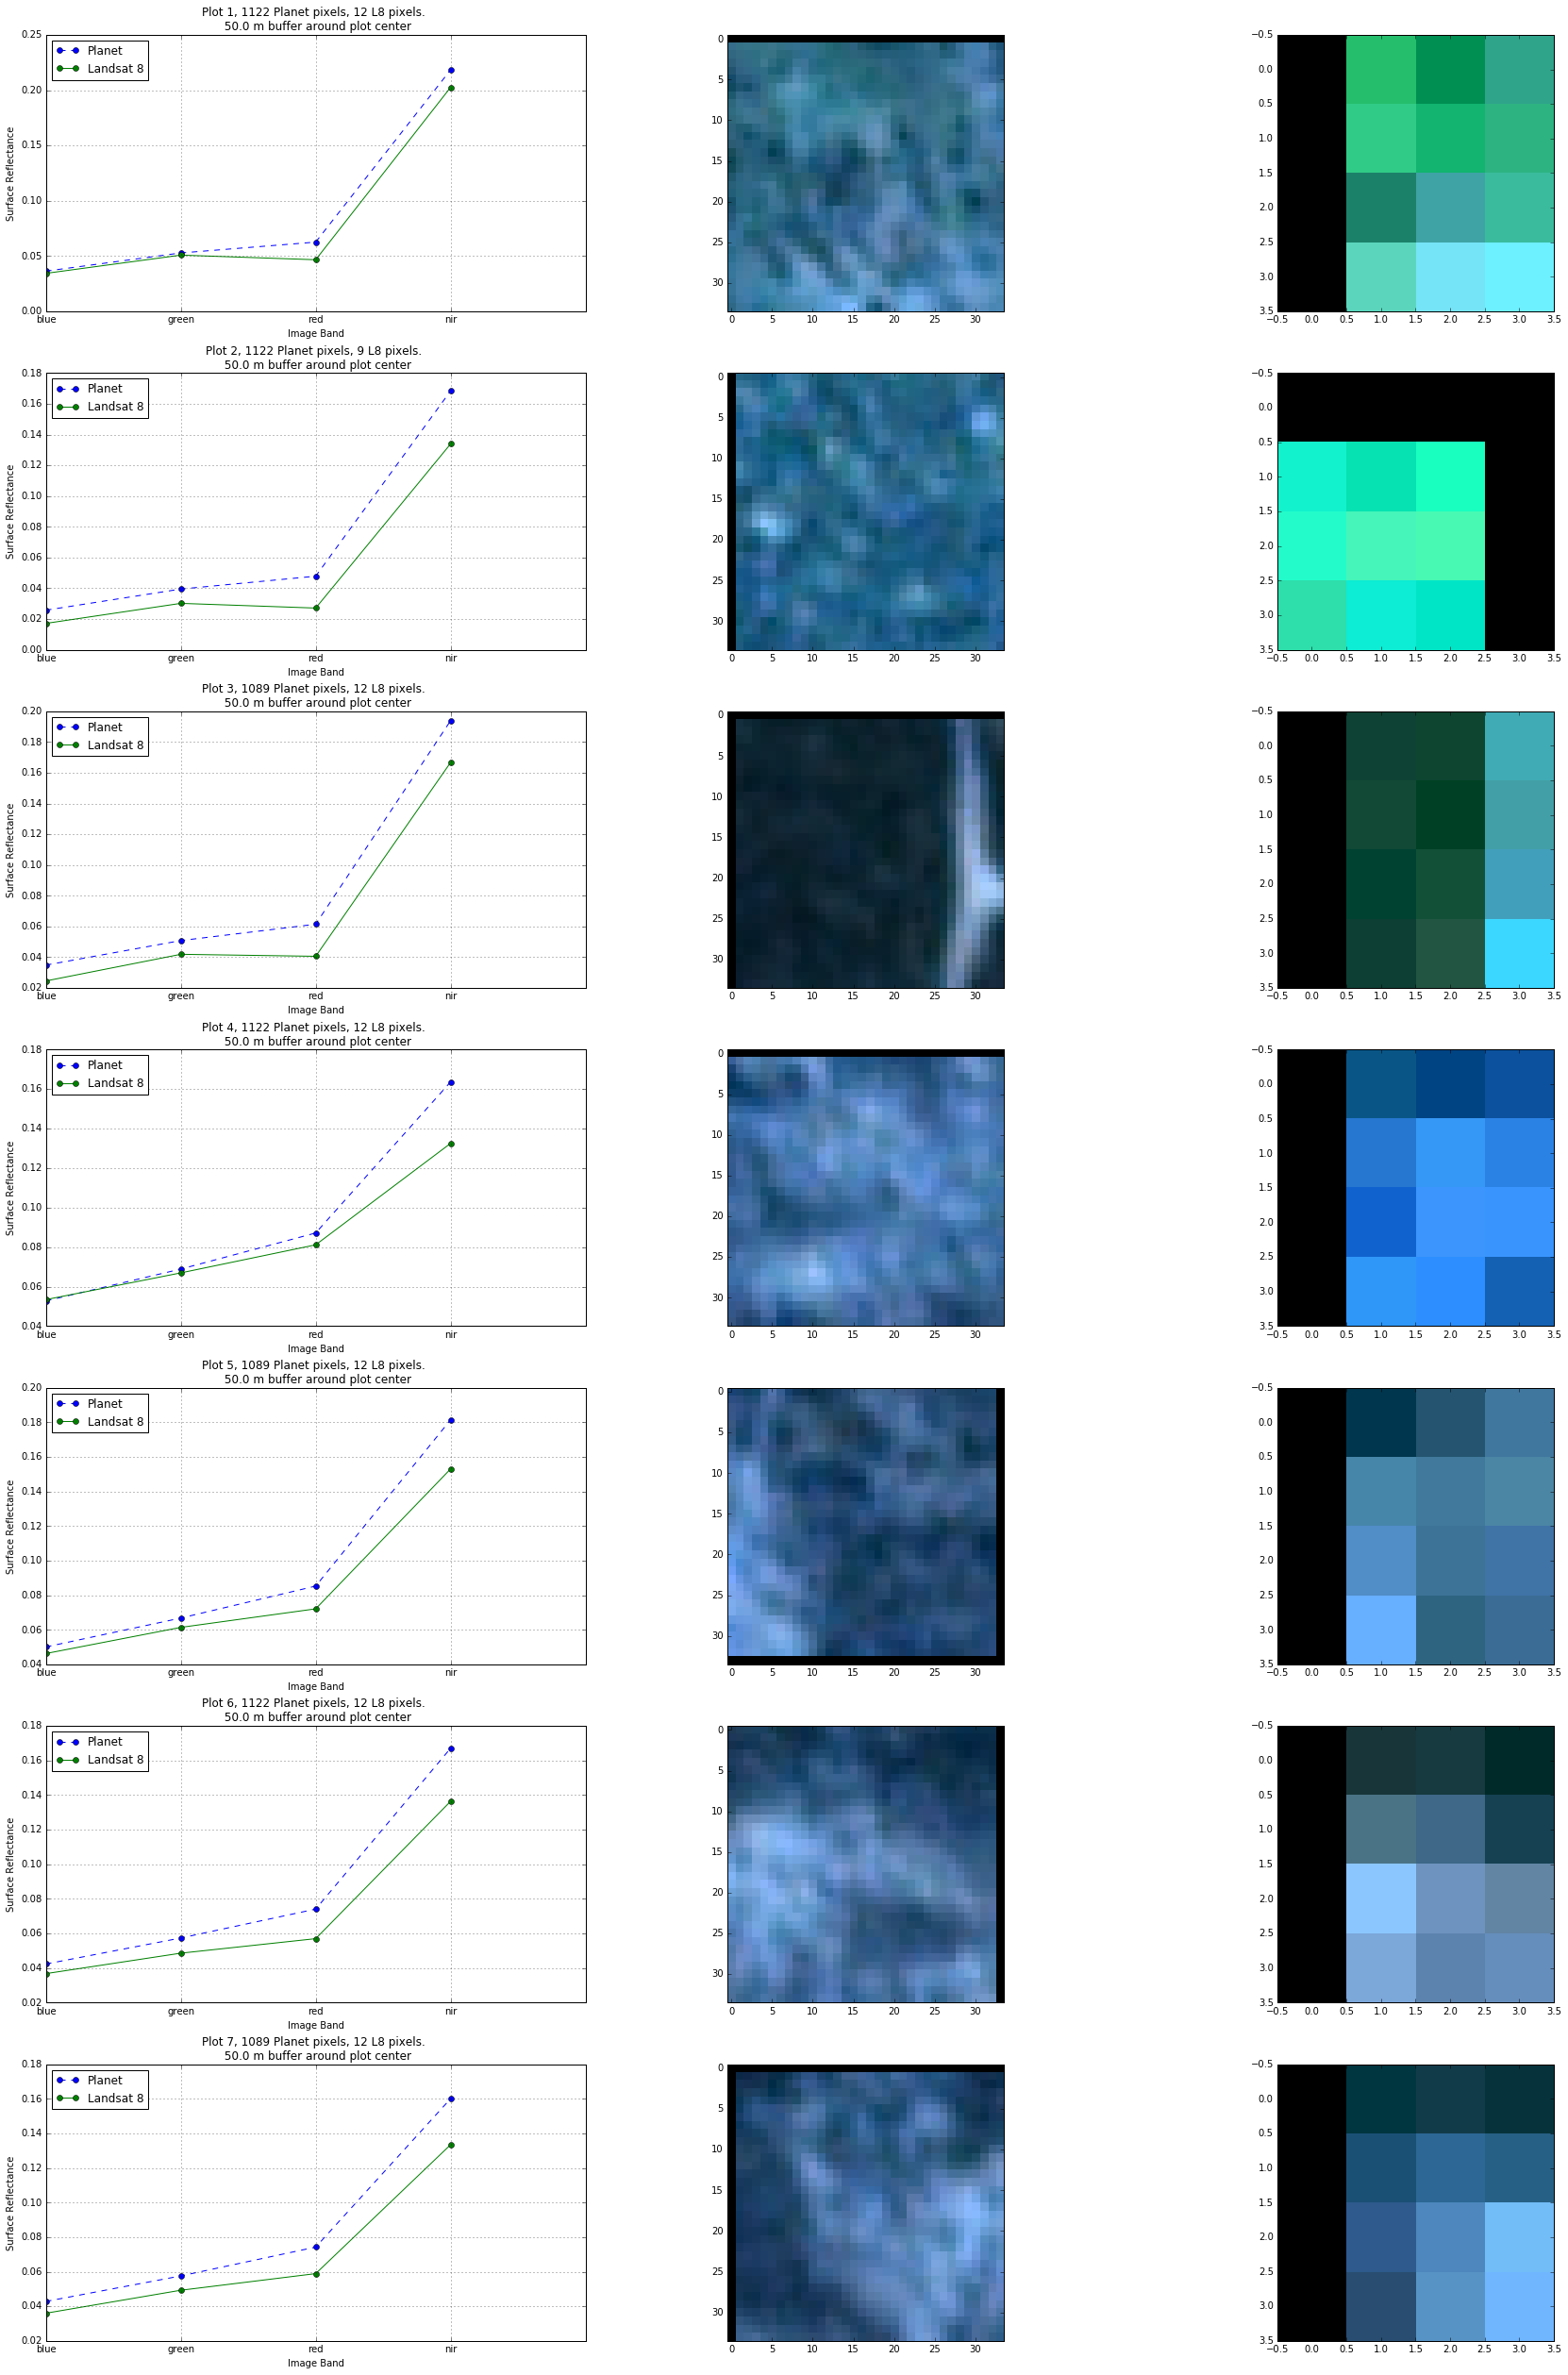

In [18]:
%matplotlib inline
#plt.figure(figsize=(50,20))
fsize=(15,25)
fsize=(25,35)
plt.figure(figsize=fsize)
for i in range(7):
    
    # plot the band means
#     plt.figure(figsize = fsize)
    pos = 3*i + 1
    plt.subplot(7,3, pos)
        
    plt.plot(test[i]['sr_means'], '--o', label="Planet")
    plt.plot(test_landsat[i]['sr_means'], '-o',label="Landsat 8")
    plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(i+1, test[i]['numpixels'],test_landsat[i]['numpixels'], buffer_distance))
    plt.legend(loc='upper left')
    xmarks = range(0, 4+1, 1)
    plt.xticks(xmarks)
    plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
    plt.xlabel('Image Band')
    plt.ylabel('Surface Reflectance')
    plt.grid()
    plt.tight_layout()
    
    
    # show the planet image
    #plt.figure(figsize = fsize)
    plt.subplot(7,3,pos+1)
    a = np.rollaxis(test[i]['image'][0:3,:,:],0,3)
    a.shape
    plt.imshow(misc.bytescale(a), interpolation='nearest')
    
    # show the landsat image
    #plt.figure(figsize = fsize)
    plt.subplot(7,3,pos+2)
    a = np.rollaxis(test_landsat[i]['image'][0:3,:,:], 0,3)
    plt.imshow(misc.bytescale(a), interpolation='nearest')
 

plt.savefig(r'C:\projects\rd\planet\test.png')

In [19]:
def plotBandMeansImagesAndSave(planet_res, landsat_res, buffer_size, plotfilename):
    fsize=(15,25)
    fsize=(25,35)
    plt.figure(figsize=fsize)
    for i in range(7):

        # plot the band means
    #     plt.figure(figsize = fsize)
        pos = 3*i + 1
        plt.subplot(7,3, pos)

        plt.plot(planet_res[i]['sr_means'], '--o', label="Planet")
        plt.plot(landsat_res[i]['sr_means'], '-o',label="Landsat 8")
        plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(i+1, planet_res[i]['numpixels'],landsat_res[i]['numpixels'], buffer_size))
        plt.legend(loc='upper left')
        xmarks = range(0, 4+1, 1)
        plt.xticks(xmarks)
        plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
        plt.xlabel('Image Band')
        plt.ylabel('Surface Reflectance')
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,-0.05,0.5))
        plt.grid()
        plt.tight_layout()


        # show the planet image
        #plt.figure(figsize = fsize)
        plt.subplot(7,3,pos+1)
        a = np.rollaxis(planet_res[i]['image'][0:3,:,:],0,3)
        a.shape
        plt.imshow(misc.bytescale(a), interpolation='nearest')

        # show the landsat image
        #plt.figure(figsize = fsize)
        plt.subplot(7,3,pos+2)
        a = np.rollaxis(landsat_res[i]['image'][0:3,:,:], 0,3)
        plt.imshow(misc.bytescale(a), interpolation='nearest')


    plt.savefig(plotfilename)
    return

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:32: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


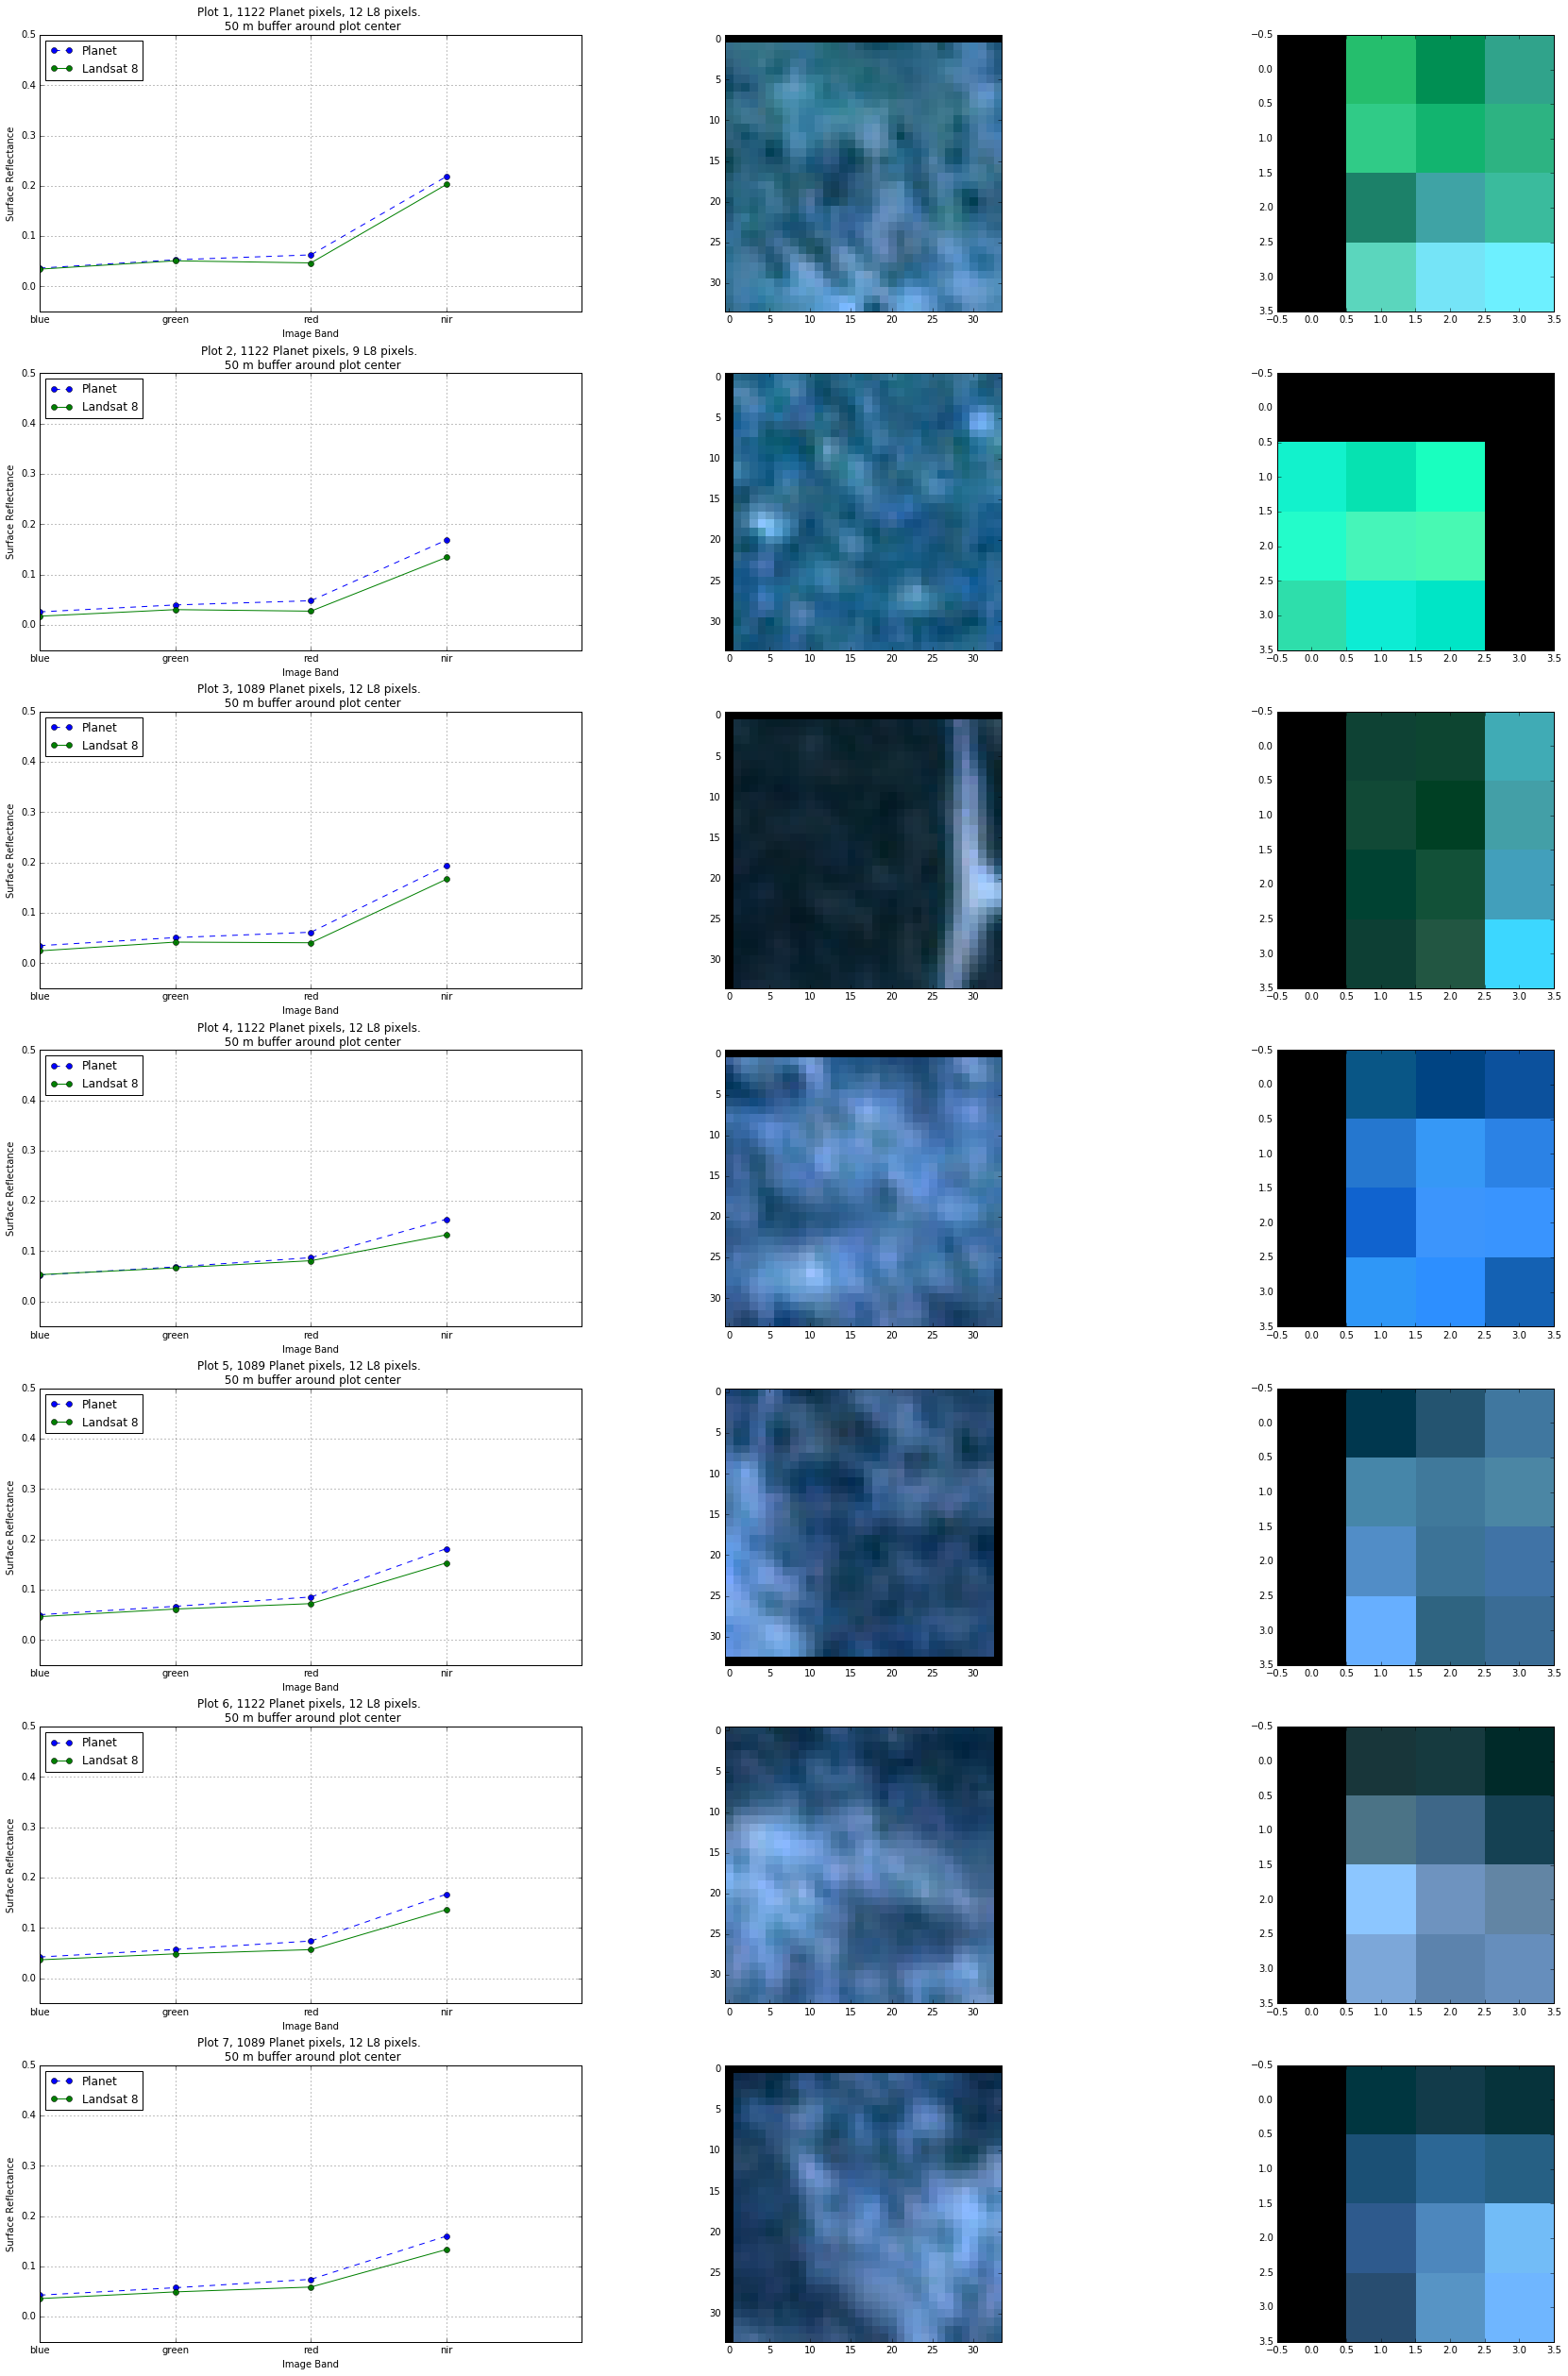

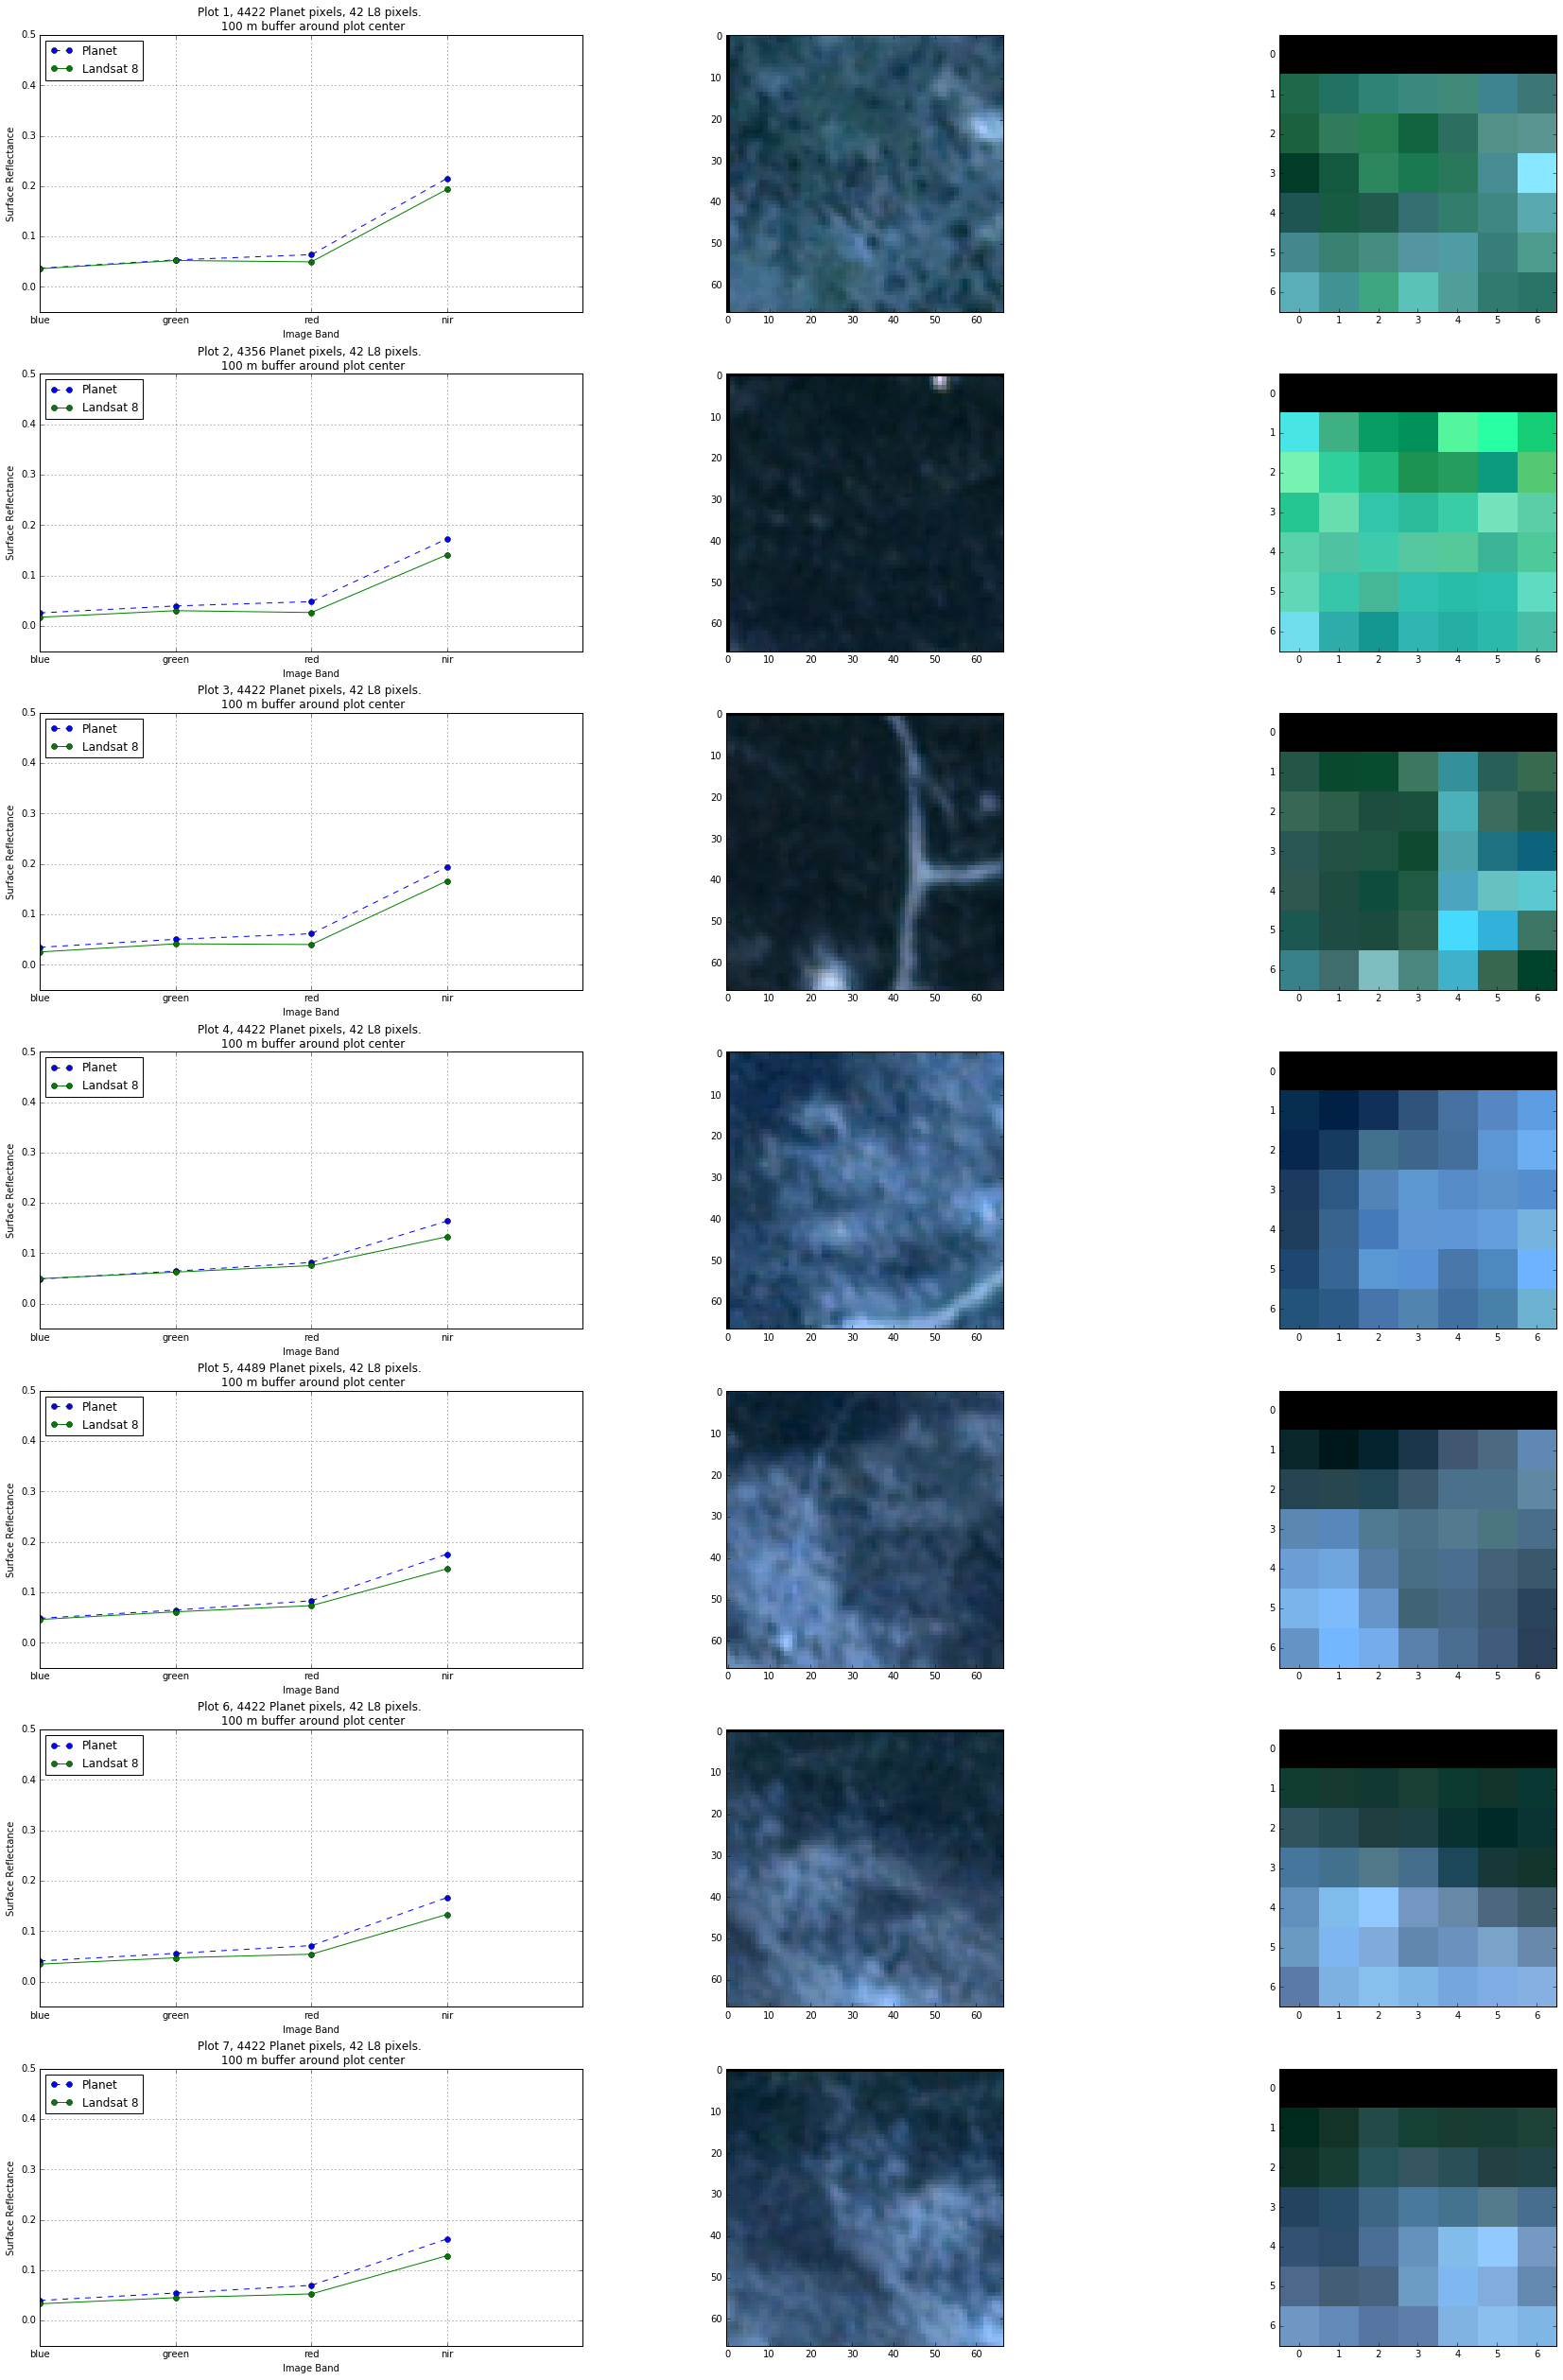

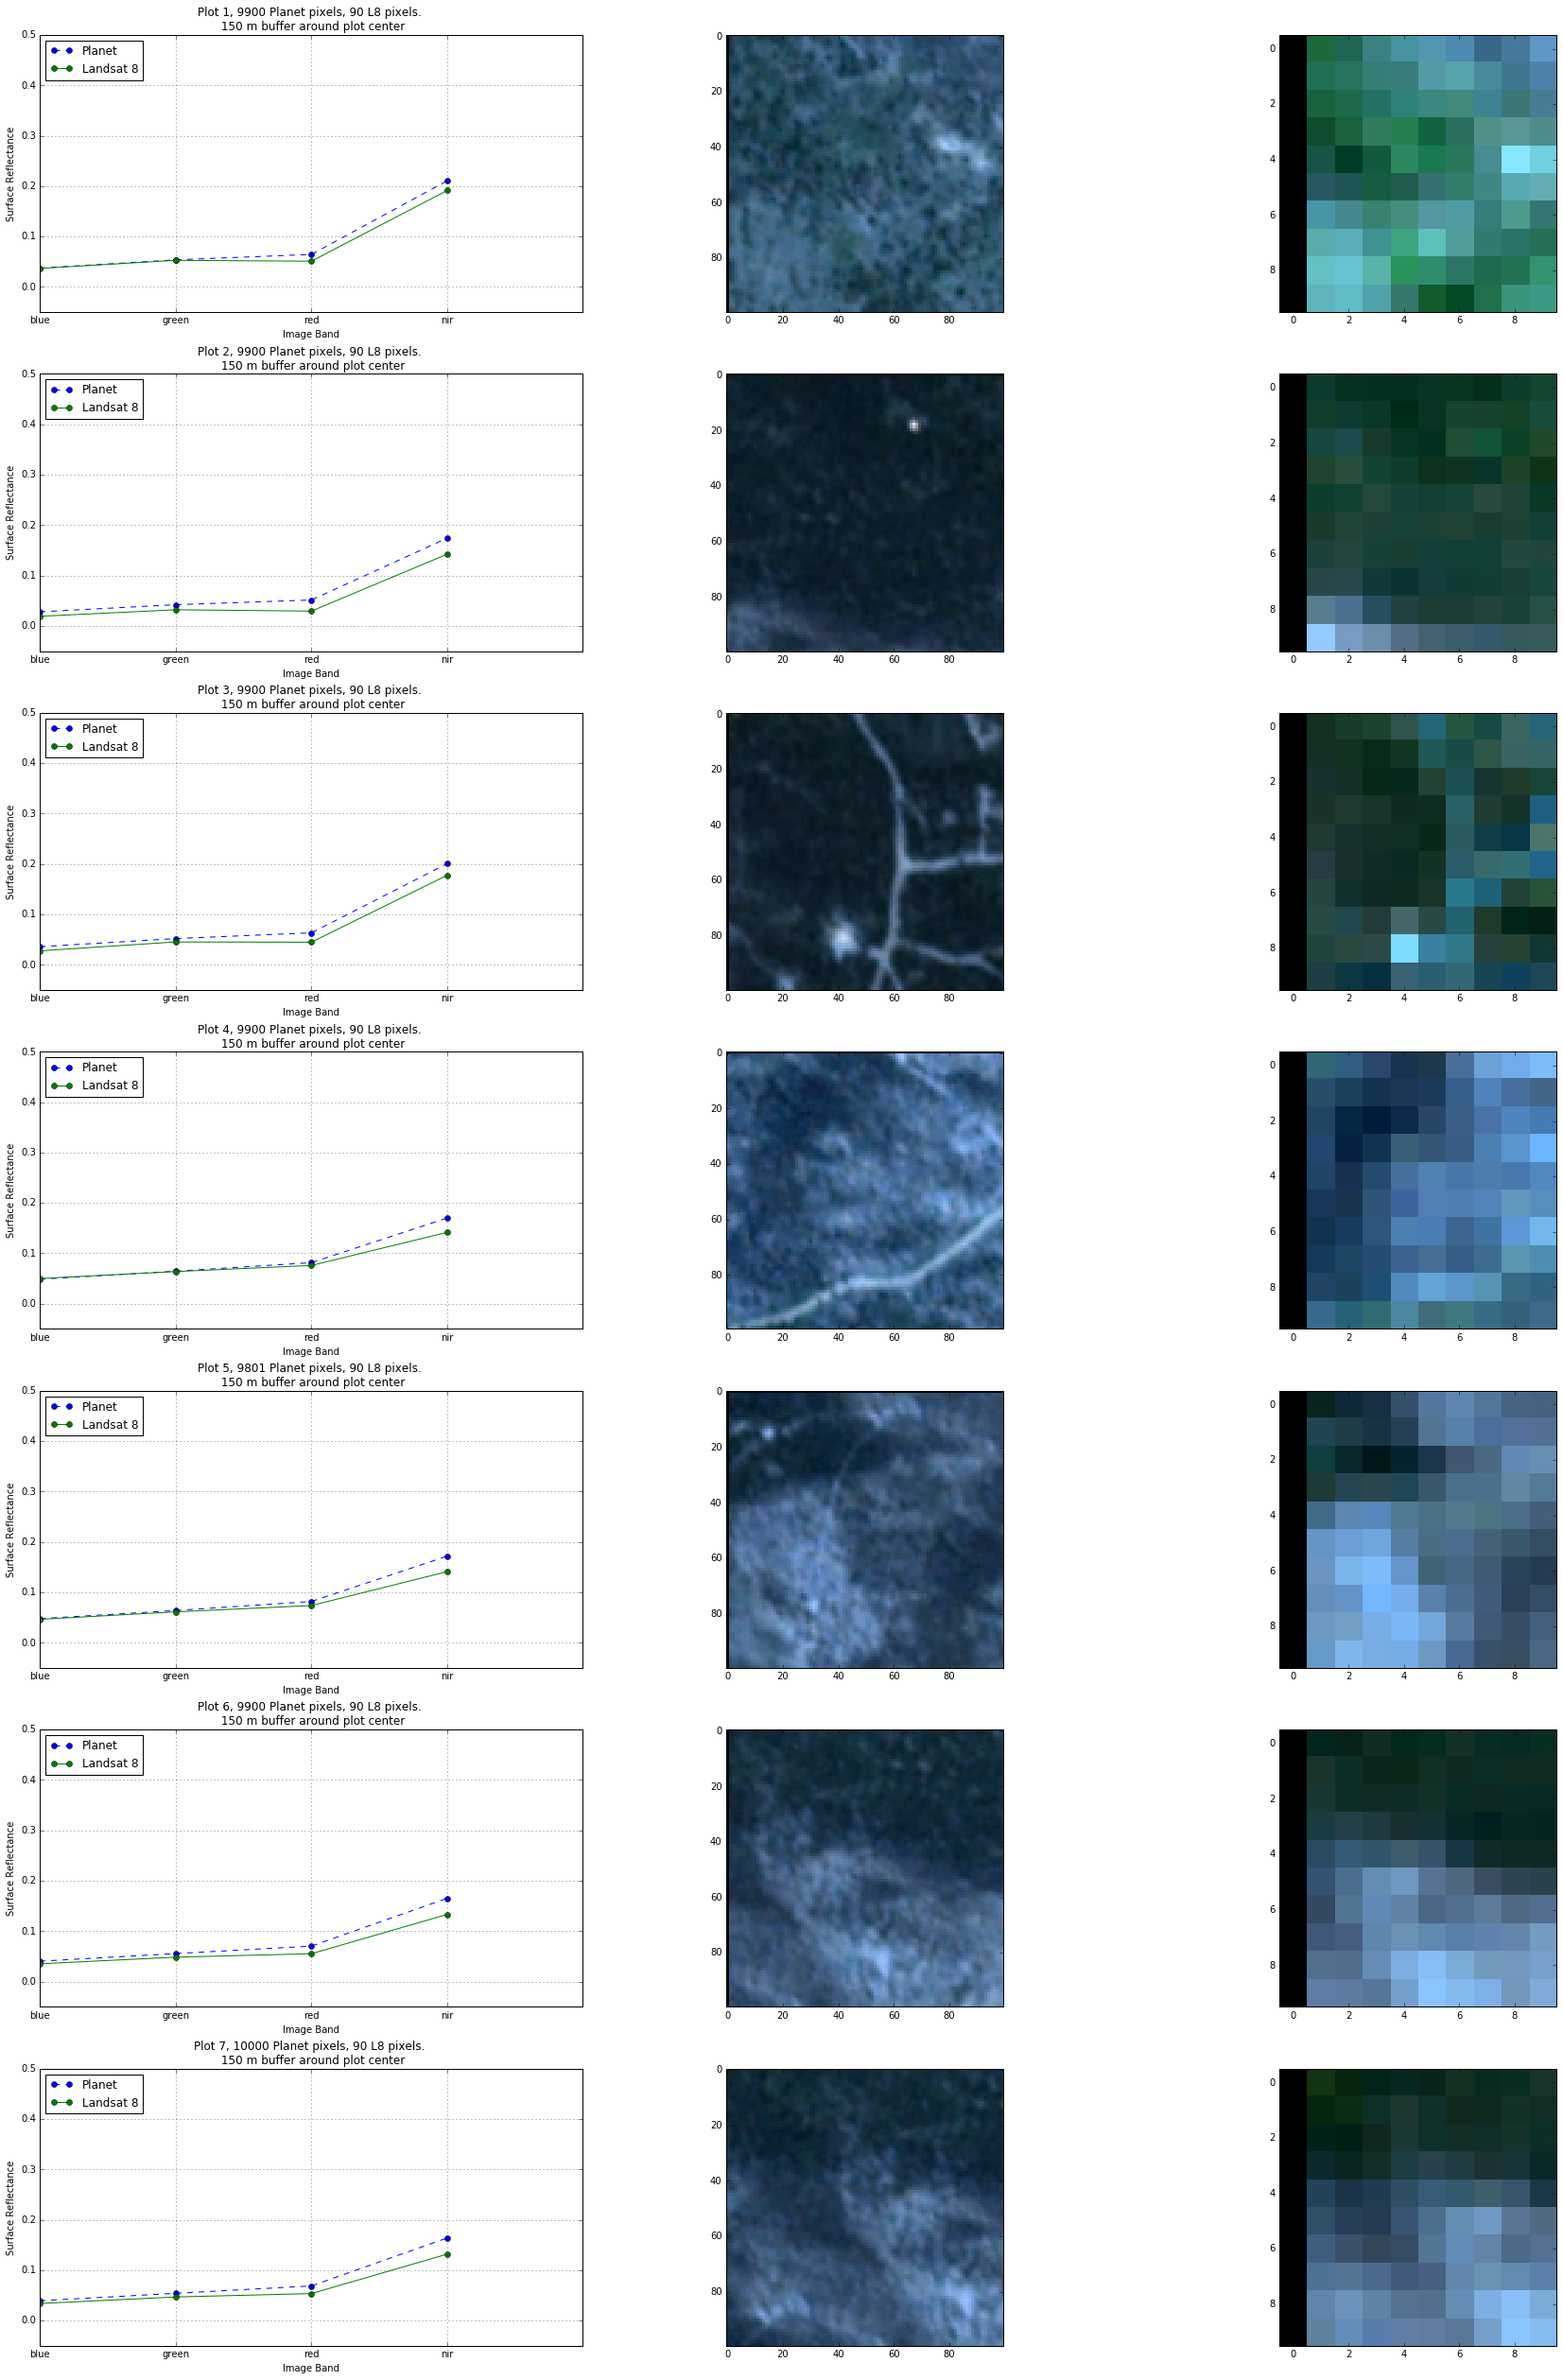

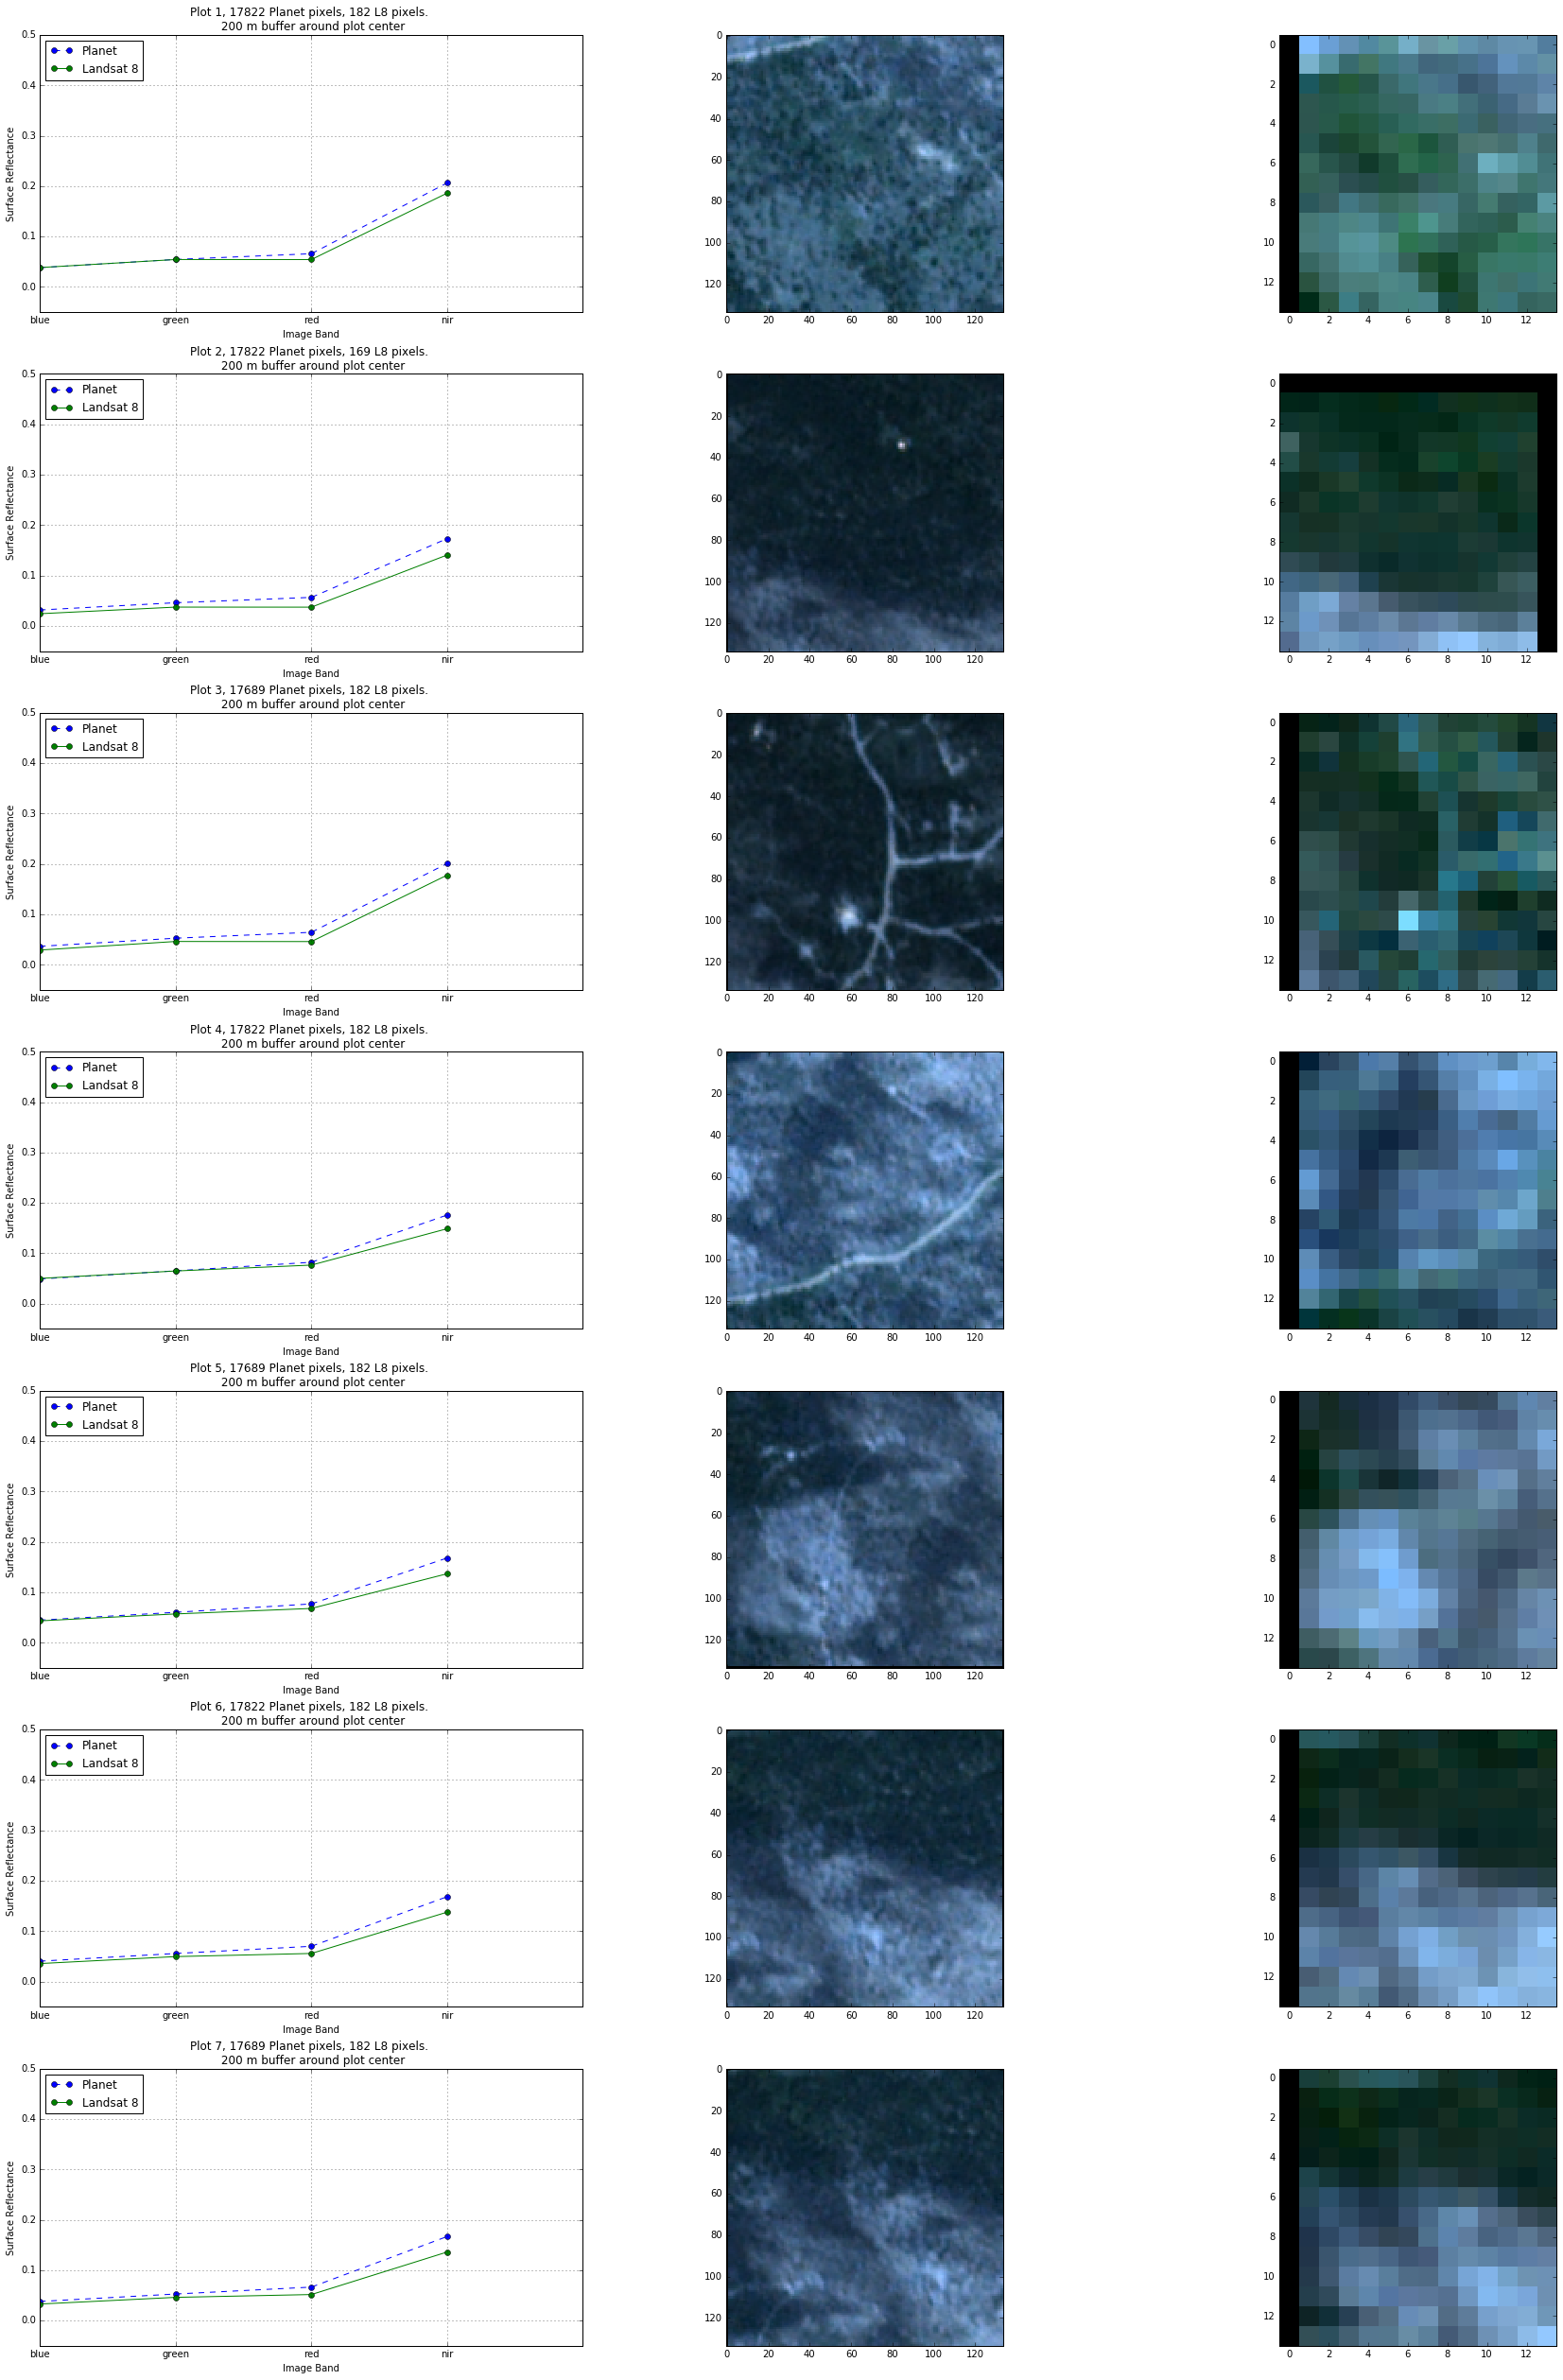

In [20]:
buf_sizes = [50, 100, 150, 200]
fig_dir = r'C:\projects\rd\planet\figs\compare_landsat'
for buf in buf_sizes:
    plot_fi = os.path.join(fig_dir, 'planet_landsat_compare_buffer_{}_m.png'.format(buf))
    
    # buffer out. square capping.
    buffer_distance = buf
    buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

    # convert them back to geojson
    buffers = [mapping(b) for b in buffer_p]
    planet_r = [meanIntensityOverGeometry_simple(planet_image, planet_xml, p) for p in buffers]
    landsat_r = [meanIntensityOverGeometry_simple_Landsat(landsat_bandfiles, p) for p in buffers]
    
    plotBandMeansImagesAndSave(planet_r, landsat_r, buf, plot_fi)
    

In [21]:
test[6]['dates']

'2017-08-27'

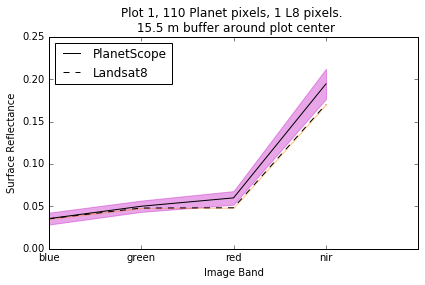

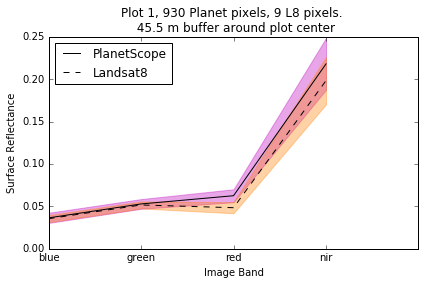

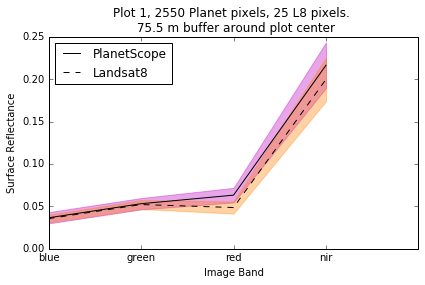

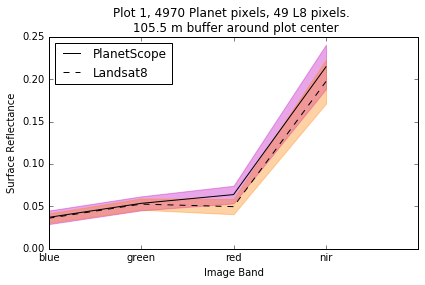

********************************************************************************


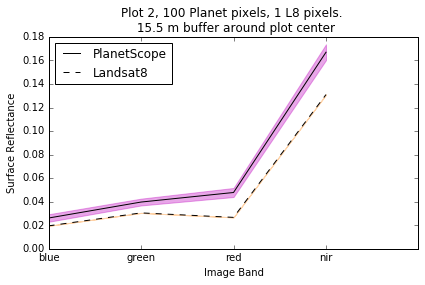

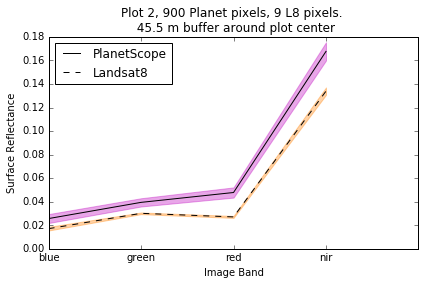

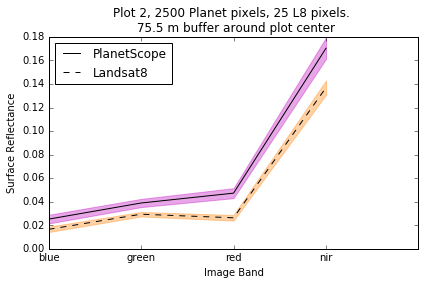

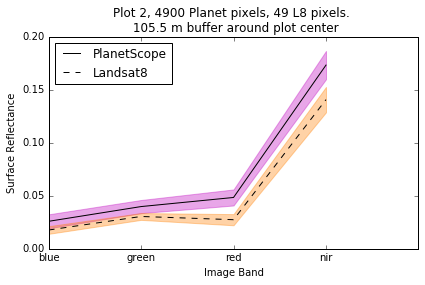

********************************************************************************


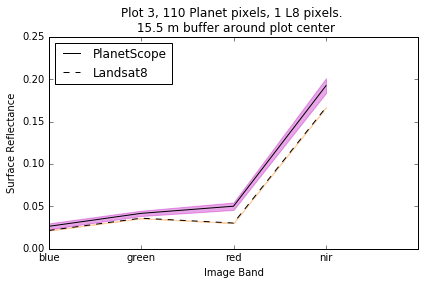

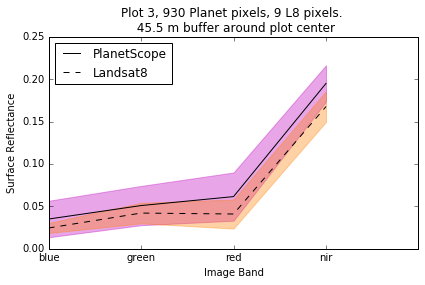

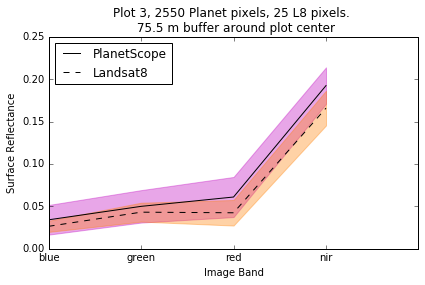

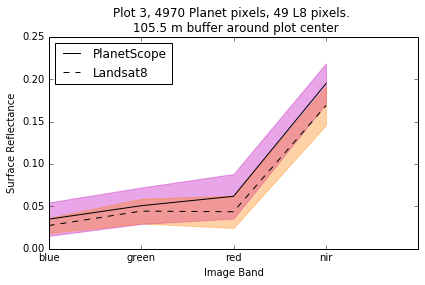

********************************************************************************


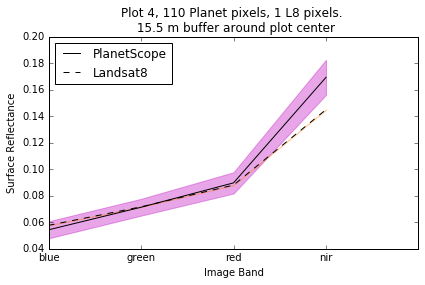

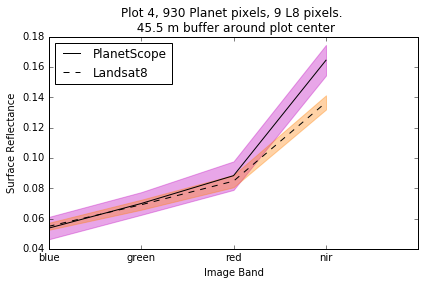

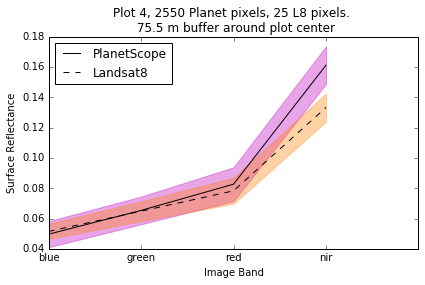

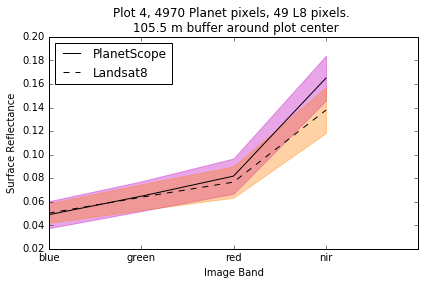

********************************************************************************


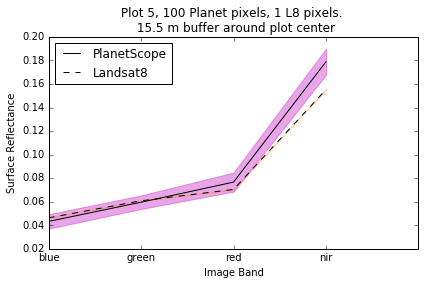

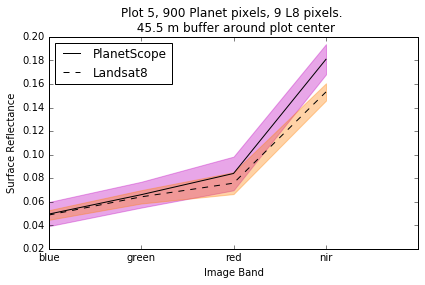

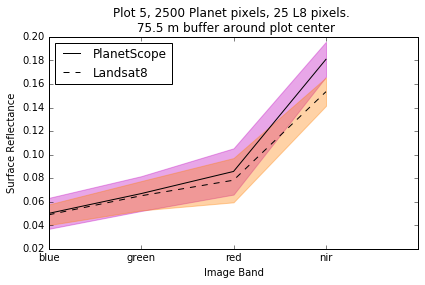

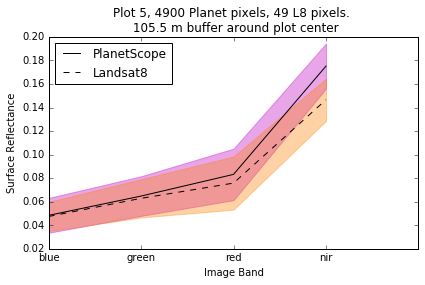

********************************************************************************


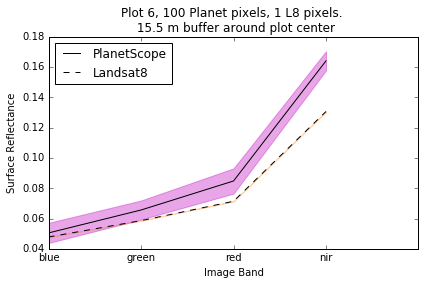

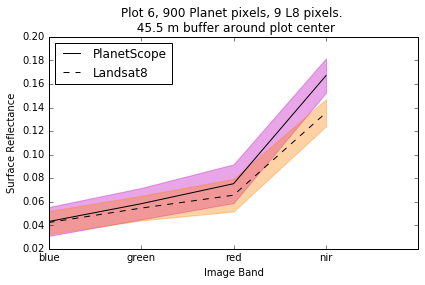

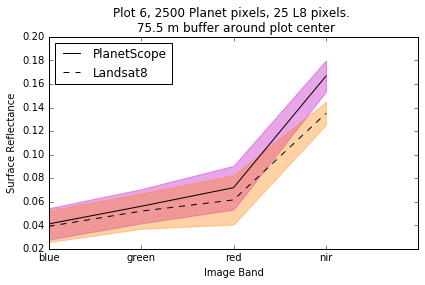

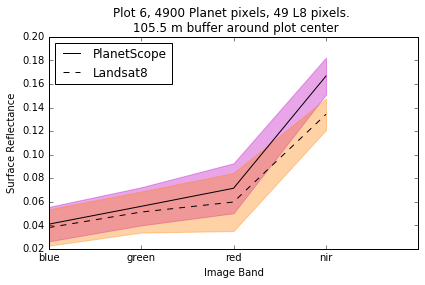

********************************************************************************


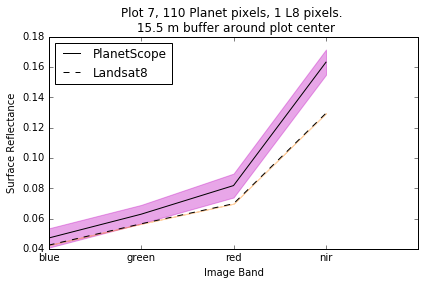

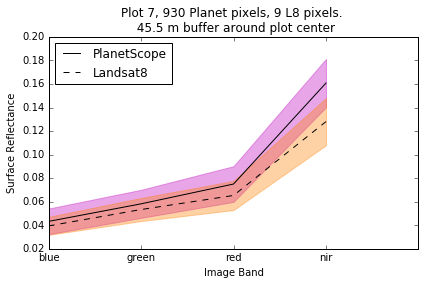

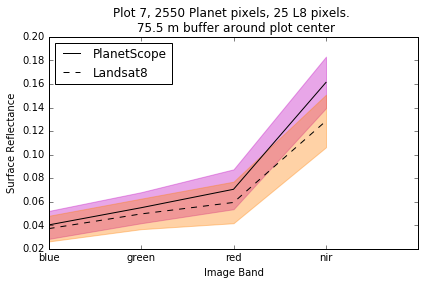

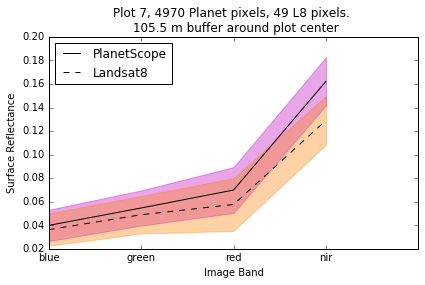

********************************************************************************


In [22]:
## check out some fill between plots for 1x1, 3x3, 5x5, 7x7 windows around plot center, relative to landsat pixels
buf_sizes = [31, 91, 151, 211]
buf_sizes = [float(i)/2 for i in buf_sizes]
fig_dir = r'C:\projects\rd\planet\figs\compare_landsat'

plot_ind=0
for plot_ind in range(7):
    for buf in buf_sizes:
        plot_fi = os.path.join(fig_dir, 'planet_landsat_compare_buffer_{}_m.png'.format(buf))

        # buffer out. square capping.
        buffer_distance = buf
        buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

        # convert them back to geojson
        buffers = [mapping(b) for b in buffer_p]
        planet_r = [meanIntensityOverGeometry_simple(planet_image, planet_xml, p) for p in buffers]
        landsat_r = [meanIntensityOverGeometry_simple_Landsat(landsat_bandfiles, p) for p in buffers]

        x = np.arange(4)
        y = np.array(planet_r[plot_ind]['sr_means'])
        err = np.array(planet_r[plot_ind]['sr_std'])

        y_l = np.array(landsat_r[plot_ind]['sr_means'])
        err_l = np.array(landsat_r[plot_ind]['sr_std'])

        plt.plot(x,y, 'k-', label='PlanetScope')
        plt.fill_between(x, y-err, y+err, alpha=0.35, color='m')

        plt.plot(x,y_l, 'k--', label='Landsat8')
        plt.fill_between(x, y_l-err_l, y_l+err_l, alpha=0.35, color=[255./255,128./255,0])


        #plt.errorbar(x, landsat_r[i]['sr_means'], yerr=test_landsat[i]['sr_std'], fmt='-o',label="Landsat 8")


        plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(plot_ind+1, planet_r[plot_ind]['numpixels'],landsat_r[plot_ind]['numpixels'], buffer_distance))
        plt.legend(loc='upper left')
        xmarks = range(0, 4+1, 1)
        plt.xticks(xmarks)
        plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
        plt.xlabel('Image Band')
        plt.ylabel('Surface Reflectance')
        plt.tight_layout()
        plt.show()

    print('********************************************************************************')
    

In [23]:
print(planet_r[0].keys())

['dates', 'sr_means', 'numpixels', 'image', 'sr_std']


C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


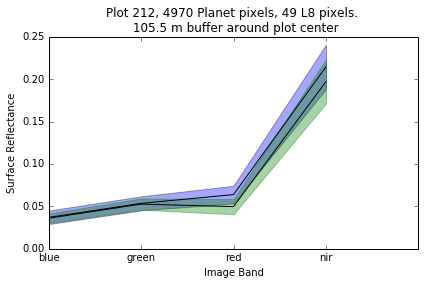

In [24]:
x = np.arange(4)
y = np.array(planet_r[0]['sr_means'])
err = np.array(planet_r[0]['sr_std'])

y_l = np.array(landsat_r[0]['sr_means'])
err_l = np.array(landsat_r[0]['sr_std'])

plt.plot(x,y, 'k-')
plt.fill_between(x, y-err, y+err, alpha=0.35)

plt.plot(x,y_l, 'k-')
plt.fill_between(x, y_l-err_l, y_l+err_l, alpha=0.35, color='g')


#plt.errorbar(x, landsat_r[i]['sr_means'], yerr=test_landsat[i]['sr_std'], fmt='-o',label="Landsat 8")


plt.title('Plot {}, {} Planet pixels, {} L8 pixels. \n {} m buffer around plot center'.format(i+1, planet_r[0]['numpixels'],landsat_r[0]['numpixels'], buffer_distance))
plt.legend(loc='upper left')
xmarks = range(0, 4+1, 1)
plt.xticks(xmarks)
plt.gca().set_xticklabels(['blue', 'green', 'red', 'nir'])
plt.xlabel('Image Band')
plt.ylabel('Surface Reflectance')
plt.tight_layout()
plt.show()



In [25]:
planet_r[0]['dates']

'2017-08-27'

In [26]:
len(planet_r)

7

In [27]:
planet_r[0].keys()

['dates', 'sr_means', 'numpixels', 'image', 'sr_std']

In [28]:
red = planet_r[0]['image'][2,:,:]
nir = planet_r[0]['image'][3,:,:]



(4L, 71L, 71L)